### Plots for the paper

In [1]:
################## IMPORT LIBRARIES ##################
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import soundfile as sf
from IPython.display import Audio, display, HTML
import torch
from os.path import join as pjoin

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io.wavfile as wavfile
from scipy import stats
import pyloudnorm as pyln




In [2]:
def set_rms_level(signal, target_db=-20):
    """ Normalize signal to a specific RMS level in dB FS """
    rms_current = np.sqrt(np.mean(signal**2))  # Compute current RMS
    rms_target = 10 ** (target_db / 20)  # Convert dB to linear RMS value

    if rms_current > 0:
        signal = signal * (rms_target / rms_current)  # Scale signal
    return signal


# ANALYZE THE MUSHRA SAMPLES
filenames=[]
levels=[]
lufs = []
lufs_new = []
levels_new=[]
example=[]


for i in range(0,10):
    for filename in glob.glob(os.path.join(f"../sounds/Mushra/Sample{i+1}/", '*.wav')):
        fs, x = wavfile.read(filename)
        x = x.astype(np.float32)
        filenames.append(filename)
        levels.append(20*np.log10(np.sqrt(np.mean(x**2))))

        # set RMS:
        # x_new=set_rms_level(x,-20)

        # set LOUDNESS:
        meter = pyln.Meter(48000) 
        loudness = meter.integrated_loudness(x)
        lufs.append(loudness)
        example.append(i+1)

        # loudness normalize audio to -12 dB LUFS
        x_new = pyln.normalize.loudness(x, loudness, -22.0)
        lufs_new.append(meter.integrated_loudness(x_new))

        levels_new.append(20*np.log10(np.sqrt(np.mean(x_new**2))))

        # Overwrite the WAV file
        wavfile.write(filename, 48000, x_new.astype(np.float32))


samples=pd.DataFrame([])
samples["filename"]=filenames
samples["level"]=levels_new
samples["lufs"]=lufs_new
samples["condition"]=np.NaN 
samples["example"]=example


samples.loc[samples["filename"].str.contains("target"),"condition"]="target"
samples.loc[samples["filename"].str.contains("content"),"condition"]="content"
samples.loc[samples["filename"].str.contains("stft"),"condition"]="stft+wav"
samples.loc[samples["filename"].str.contains("logmel"),"condition"]="logmel+wav"
samples.loc[samples["filename"].str.contains("anecho"),"condition"]="anecho+fins"
samples.loc[samples["filename"].str.contains("dfnet"),"condition"]="dfnet+fins"
samples.loc[samples["filename"].str.contains("wpe"),"condition"]="wpe+fins"


display(samples.groupby("condition")["level"].std())


pd.set_option('display.max_colwidth', None)  
samples.head(10)

condition
anecho+fins    1.485639
content        1.393642
dfnet+fins     1.547798
logmel+wav     1.355407
stft+wav       1.354026
target         1.421946
wpe+fins       1.385814
Name: level, dtype: float64

,filename,level,lufs,condition,example
0,../sounds/Mushra/Sample1/20-05-2024--22-48_c_wunet_logmel+wave_0.8_0.2_b12_i0_prediction.wav,-24.701388,-22.0,logmel+wav,1
1,../sounds/Mushra/Sample1/10-06-2024--15-02_c_wunet_stft+wave_0.8_0.2_b12_i0_prediction.wav,-24.615653,-22.0,stft+wav,1
2,../sounds/Mushra/Sample1/anecho+fins_b12_i0_prediction.wav,-24.761643,-22.0,anecho+fins,1
3,../sounds/Mushra/Sample1/dfnet+fins_b12_i0_prediction.wav,-24.832659,-22.0,dfnet+fins,1
4,../sounds/Mushra/Sample1/b12_i0_content.wav,-24.789140,-22.0,content,1
5,../sounds/Mushra/Sample1/wpe+fins_b12_i0_prediction.wav,-24.797921,-22.0,wpe+fins,1
6,../sounds/Mushra/Sample1/b12_i0_target.wav,-24.712453,-22.0,target,1
7,../sounds/Mushra/Sample2/dfnet+fins_b10_i2_prediction.wav,-24.299879,-22.0,dfnet+fins,2
8,../sounds/Mushra/Sample2/b10_i2_target.wav,-23.962176,-22.0,target,2
9,../sounds/Mushra/Sample2/anecho+fins_b10_i2_prediction.wav,-24.015265,-22.0,anecho+fins,2


In [3]:

# Load the dataset
file_path = "mushra_lufs_results.csv"
df = pd.read_csv(file_path, sep=";", on_bad_lines='skip') 

df=df.iloc[0:,3:].T.reset_index()
df = df.drop(columns=["index"])

df.rename(columns={df.columns[0]: "audio_file"}, inplace=True)
df.rename(columns={df.columns[1]: "trial"}, inplace=True)
for i in range(2, len(df.columns)):
    df.rename(columns={df.columns[i]: f"user{i-2}"}, inplace=True)

df["trial"]=df["trial"].fillna(method='ffill', limit=6)

df = df[~df["trial"].isin(["Audio Example 5 rating"])]

df["condition"]=np.nan
df.loc[df["audio_file"].str.contains("target"),"condition"]="target"
df.loc[(df["audio_file"].str.contains("stft") & df["audio_file"].str.contains("prediction")),"condition"]="stft+wav"
df.loc[(df["audio_file"].str.contains("logmel") & df["audio_file"].str.contains("prediction")),"condition"]="logmel+wav"
df.loc[(df["audio_file"].str.contains("anecho") & df["audio_file"].str.contains("prediction")),"condition"]="anecho+fins"
df.loc[(df["audio_file"].str.contains("dfnet") & df["audio_file"].str.contains("prediction")),"condition"]="dfnet+fins"
df.loc[(df["audio_file"].str.contains("wpe") & df["audio_file"].str.contains("prediction")),"condition"]="wpe+fins"
df.loc[df["audio_file"].str.contains("content"),"condition"]="content"

df["revdiff"]=np.nan
df.loc[df["trial"].str.contains("9"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("5"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("4"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("6"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("8"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("1"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("3"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("7"),"revdiff"]="rev2dry"
df.loc[df["trial"].str.contains("10"),"revdiff"]="dry2rev"
df.loc[df["trial"].str.contains("2"),"revdiff"]="dry2rev"

df.head(20)

,audio_file,trial,user0,user1,user2,user3,user4,user5,user6,user7,user8,user9,user10,user11,user12,condition,revdiff
0,b12_i0_target.wav,Audio Example 1 rating,100,100,100,100,92,80,100,75,100,100,43,97,100,target,dry2rev
1,b12_i0_content.wav,Audio Example 1 rating,18,0,50,22,87,0,0,22,0,0,9,0,0,content,dry2rev
2,10-06-2024--15-02_c_wunet_stft+wave_0.8_0.2_b12_i0_prediction.wav,Audio Example 1 rating,61,29,50,92,96,100,0,51,22,91,71,82,50,stft+wav,dry2rev
3,20-05-2024--22-48_c_wunet_logmel+wave_0.8_0.2_b12_i0_prediction.wav,Audio Example 1 rating,19,0,33,40,95,100,0,100,23,62,71,75,28,logmel+wav,dry2rev
4,anecho+fins_b12_i0_prediction.wav,Audio Example 1 rating,81,100,100,40,94,80,88,100,63,70,84,62,59,anecho+fins,dry2rev
5,dfnet+fins_b12_i0_prediction.wav,Audio Example 1 rating,81,37,81,86,80,40,86,27,64,51,76,40,74,dfnet+fins,dry2rev
6,wpe+fins_b12_i0_prediction.wav,Audio Example 1 rating,19,52,20,64,74,20,22,60,63,18,42,13,59,wpe+fins,dry2rev
7,b10_i2_target.wav,Audio Example 2 rating,100,100,100,80,83,100,100,19,100,100,78,99,100,target,dry2rev
8,b10_i2_content.wav,Audio Example 2 rating,20,0,20,0,75,40,0,0,0,0,34,0,0,content,dry2rev
9,10-06-2024--15-02_c_wunet_stft+wave_0.8_0.2_b10_i2_prediction.wav,Audio Example 2 rating,63,72,51,80,79,60,21,22,39,89,60,20,73,stft+wav,dry2rev


In [4]:
df.groupby(["condition"]).count()

,audio_file,trial,user0,user1,user2,user3,user4,user5,user6,user7,user8,user9,user10,user11,user12,revdiff
condition,,,,,,,,,,,,,,,,
anecho+fins,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
content,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
dfnet+fins,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
logmel+wav,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
stft+wav,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
target,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
wpe+fins,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


In [5]:
# Reshape the data using pivot_table
pivot_df = df.melt(id_vars=['condition',"trial","revdiff"], value_vars=['user0', 'user1', 'user2', 'user3', 'user4', 'user5', 'user6','user7','user8',"user9","user10","user11","user12"],
                   var_name='user', value_name='score')

pivot_df["score"]= pd.to_numeric(pivot_df["score"])

pivot_df.head(10)


,condition,trial,revdiff,user,score
0,target,Audio Example 1 rating,dry2rev,user0,100
1,content,Audio Example 1 rating,dry2rev,user0,18
2,stft+wav,Audio Example 1 rating,dry2rev,user0,61
3,logmel+wav,Audio Example 1 rating,dry2rev,user0,19
4,anecho+fins,Audio Example 1 rating,dry2rev,user0,81
5,dfnet+fins,Audio Example 1 rating,dry2rev,user0,81
6,wpe+fins,Audio Example 1 rating,dry2rev,user0,19
7,target,Audio Example 2 rating,dry2rev,user0,100
8,content,Audio Example 2 rating,dry2rev,user0,20
9,stft+wav,Audio Example 2 rating,dry2rev,user0,63


In [6]:



print(pivot_df.groupby("condition")["score"].count())

len(df)

condition
anecho+fins    117
content        117
dfnet+fins     117
logmel+wav     117
stft+wav       117
target         117
wpe+fins       117
Name: score, dtype: int64


63

In [ ]:
print("content vs stft+wav")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "content","score"],pivot_df.loc[pivot_df["condition"] == "stft+wav","score"]))
print("content vs wpe+fins")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "content","score"],pivot_df.loc[pivot_df["condition"] == "wpe+fins","score"]))
print("stft+wav vs logmel+wav")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "stft+wav","score"],pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"]))
print("logmel+wav vs wpe+fins")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"],pivot_df.loc[pivot_df["condition"] == "wpe+fins","score"]))
print("wpe+fins vs dfnet+fins")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "wpe+fins","score"],pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"]))
print("logmel+wav vs dfnet+fins")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"],pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"]))
print("dfnet+fins vs anecho+fins")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("stft+wav vs anecho+fins")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "stft+wav","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("target vs anecho+fins")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "target","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("target vs stft+wav")
print(stats.wilcoxon(pivot_df.loc[pivot_df["condition"] == "target","score"],pivot_df.loc[pivot_df["condition"] == "stft+wav","score"]))


content vs stft+wav
WilcoxonResult(statistic=57.5, pvalue=4.15828162557476e-19)
stft+wav vs logmel+wav
WilcoxonResult(statistic=1117.0, pvalue=4.666689711612595e-07)
logmel+wav vs wpe+fins
WilcoxonResult(statistic=1335.0, pvalue=3.01579618017089e-07)
wpe+fins vs dfnet+fins
WilcoxonResult(statistic=184.5, pvalue=2.7704934249178785e-17)
logmel+wav vs dfnet+fins
WilcoxonResult(statistic=2924.0, pvalue=0.251341797641503)
dfnet+fins vs anecho+fins
WilcoxonResult(statistic=1239.0, pvalue=1.0515060475451406e-07)
stft+wav vs anecho+fins
WilcoxonResult(statistic=3064.0, pvalue=0.44937678031656125)
target vs anecho+fins
WilcoxonResult(statistic=405.0, pvalue=1.1480567708994235e-14)
target vs stft+wav
WilcoxonResult(statistic=519.5, pvalue=1.0913314157174978e-13)


In [8]:
print("content vs stft+wav")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "content","score"],pivot_df.loc[pivot_df["condition"] == "stft+wav","score"]))
print("stft+wav vs logmel+wav")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "stft+wav","score"],pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"]))
print("logmel+wav vs wpe+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"],pivot_df.loc[pivot_df["condition"] == "wpe+fins","score"]))
print("wpe+fins vs dfnet+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "wpe+fins","score"],pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"]))
print("logmel+wav vs dfnet+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "logmel+wav","score"],pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"]))
print("dfnet+fins vs anecho+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "dfnet+fins","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("stft+wav vs anecho+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "stft+wav","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("target vs anecho+fins")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "target","score"],pivot_df.loc[pivot_df["condition"] == "anecho+fins","score"]))
print("target vs stft+wav")
print(stats.ttest_ind(pivot_df.loc[pivot_df["condition"] == "target","score"],pivot_df.loc[pivot_df["condition"] == "stft+wav","score"]))




content vs stft+wav
Ttest_indResult(statistic=-13.903952286910219, pvalue=2.255973057834478e-32)
stft+wav vs logmel+wav
Ttest_indResult(statistic=3.752861604514661, pvalue=0.00022097767179468596)
logmel+wav vs wpe+fins
Ttest_indResult(statistic=5.87886514891429, pvalue=1.4283831835179492e-08)
wpe+fins vs dfnet+fins
Ttest_indResult(statistic=-8.484482142406138, pvalue=2.5778522506050625e-15)
logmel+wav vs dfnet+fins
Ttest_indResult(statistic=-1.272479093544388, pvalue=0.20447676785458105)
dfnet+fins vs anecho+fins
Ttest_indResult(statistic=-4.508554804685901, pvalue=1.036070504821843e-05)
stft+wav vs anecho+fins
Ttest_indResult(statistic=-1.0694498850014384, pvalue=0.2859784169290828)
target vs anecho+fins
Ttest_indResult(statistic=9.807480414714846, pvalue=3.2169227546744744e-19)
target vs stft+wav
Ttest_indResult(statistic=9.595843103615245, pvalue=1.4071139535666637e-18)


/tmp/ipykernel_179927/934308873.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=pivot_df, x="condition", y="score", capsize=0.15, errorbar=('ci', 95),order=condition_order, linestyles="", palette="dark")


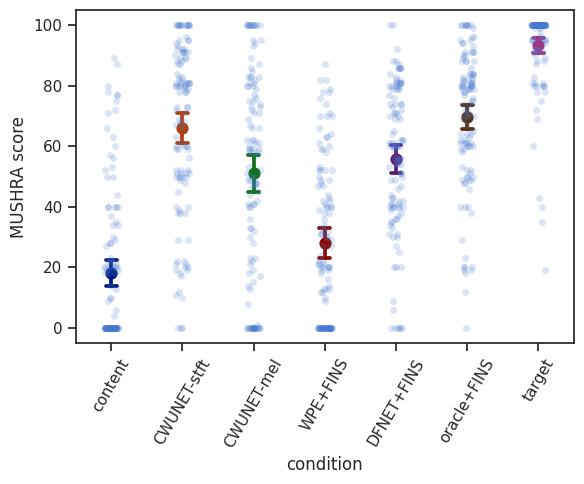

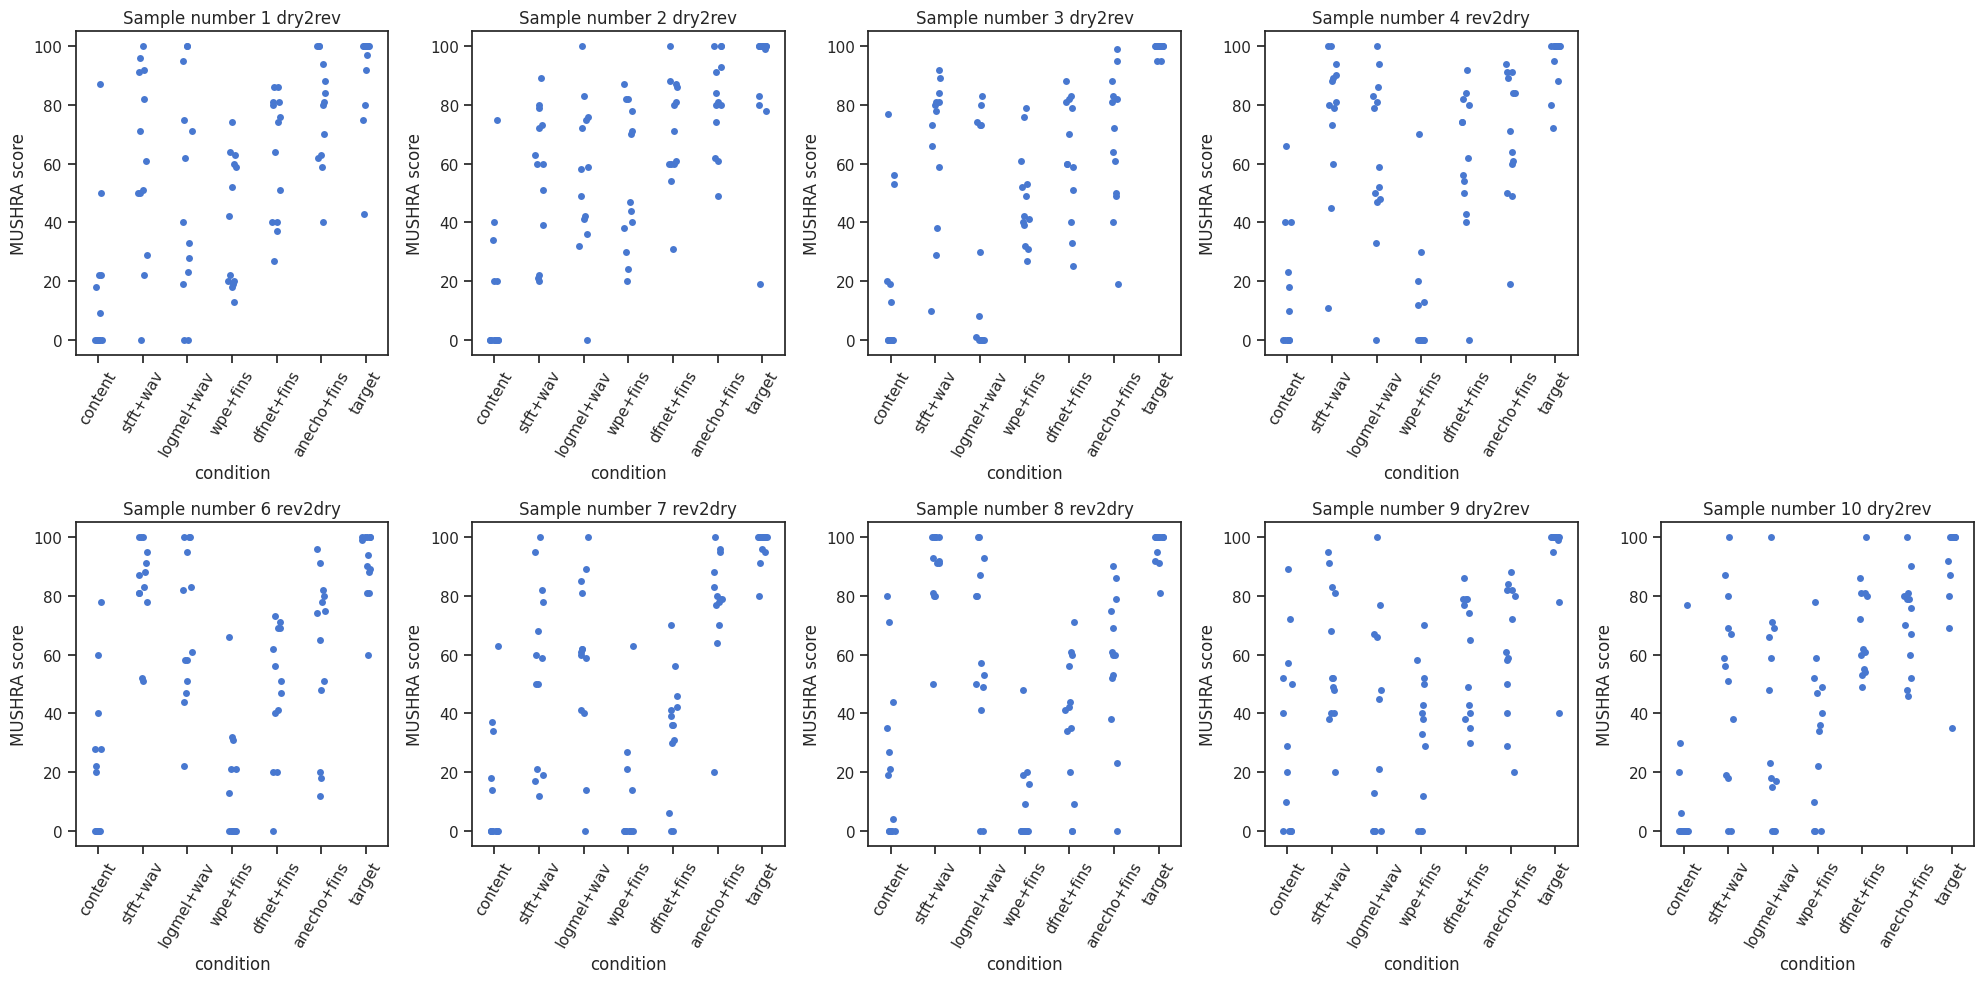

,index,condition,trial,revdiff,user,score
0,56,target,Audio Example 10 rating,dry2rev,user0,100
1,57,content,Audio Example 10 rating,dry2rev,user0,6
2,58,stft+wav,Audio Example 10 rating,dry2rev,user0,38
3,59,logmel+wav,Audio Example 10 rating,dry2rev,user0,18
4,60,anecho+fins,Audio Example 10 rating,dry2rev,user0,90
...,...,...,...,...,...,...
86,814,stft+wav,Audio Example 10 rating,dry2rev,user12,51
87,815,logmel+wav,Audio Example 10 rating,dry2rev,user12,15
88,816,anecho+fins,Audio Example 10 rating,dry2rev,user12,81
89,817,dfnet+fins,Audio Example 10 rating,dry2rev,user12,61


In [9]:
# print(pivot_df.groupby("condition").mean(numeric_only=True))
# print(pivot_df.groupby("condition").std(numeric_only=True))

sns.set_theme(style="ticks", palette="muted")
condition_order = ["content", "stft+wav", "logmel+wav", "wpe+fins", "dfnet+fins", "anecho+fins", "target"]
myxticks=["content", "CWUNET-stft", "CWUNET-mel", "WPE+FINS", "DFNET+FINS", "oracle+FINS", "target"]
plt.figure(figsize=(6,5))
sns.pointplot(data=pivot_df, x="condition", y="score", capsize=0.15, errorbar=('ci', 95),order=condition_order, linestyles="", palette="dark")
sns.stripplot(data=pivot_df, x="condition", y="score", order=condition_order,alpha=0.2)
plt.xticks(np.arange(7),myxticks,rotation=60)
plt.ylabel("MUSHRA score")
plt.title(f"")
plt.tight_layout()
plt.savefig('mushraA.pdf', format='pdf')
plt.show()


sns.set_theme(style="ticks", palette="muted")
condition_order = ["content", "stft+wav", "logmel+wav", "wpe+fins", "dfnet+fins", "anecho+fins", "target"]

plt.figure(figsize=(20,10))
# setting font sizeto 30
valid_examples=[1,2,3,4,6,7,8,9,10]
for i in valid_examples:
    one_example=pivot_df[pivot_df["trial"]==f"Audio Example {i} rating"].reset_index()
    r=one_example["revdiff"][0]
    plt.subplot(2,5,i)
    sns.stripplot(data=one_example, x="condition", y="score", order=condition_order)
    plt.ylabel("MUSHRA score")
    plt.xticks(rotation=60)
    plt.title(f"Sample number {i} " + r)
plt.tight_layout()
plt.show()



one_example